In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow_probability.substrates import numpy as tfp
from cmdstanpy import CmdStanModel, set_cmdstan_path
import arviz as az

In [14]:
import os
if not os.path.exists("./stan"):
    os.mkdir("./stan")

In [8]:
Y = pd.read_csv("../Datasets/Dataset_180.csv")
Y['Count_180'] = pd.to_numeric(Y['Count_180']).astype('Int64')

In [9]:
X = pd.read_csv("../Datasets/variables_to_select.csv")

In [10]:
rows_to_drop_Y = Y[Y['Count_180'].isna()].index

# Remove corresponding rows from dataset X
X = X.drop(index=rows_to_drop_Y)
Y = Y.drop(index=rows_to_drop_Y)

# If you want to reset the index after dropping rows
X = X.reset_index(drop=True)
Y = Y.reset_index(drop=True)

In [11]:
Y.head

<bound method NDFrame.head of       Count_180  idSensore  Year  Month
0             0       5707  2010      4
1             0       5707  2010      5
2             7       5707  2010      6
3            12       5707  2010      7
4             1       5707  2010      8
...         ...        ...   ...    ...
3803          3      12020  2022      6
3804          0      12020  2022      7
3805          0      12020  2022      8
3806          0      12020  2022      9
3807          0      12020  2022     10

[3808 rows x 4 columns]>

In [12]:
stations = Y['idSensore']
years = Y['Year'] - 2009
unique_values = sorted(set(stations))
mapping_dict = {value: index + 1 for index, value in enumerate(unique_values)}
transformed_stations = [mapping_dict[value] for value in stations]
stations_original = stations
stations = transformed_stations

In [15]:
base_model = """

data {
  int<lower=1> N; // Number of observations
  int<lower=1> P; // Covariate number

  array[N] int<lower=0> y; // Count data
  matrix[N, P] X; // Predictor matrix
}

parameters {
  vector[P] beta; // Coefficients for predictors
}

transformed parameters {
    vector[N] lambda;
    vector[N] fix_eff;

    fix_eff = X * beta;

    lambda = exp(fix_eff);
}

model {

  beta ~ normal(0, 2);
  y[1:N] ~ poisson(lambda[1:N]);

}
generated quantities{
 vector[N] log_lik;
 vector[N] y_pred;
 
 for(i in 1:N){
   log_lik[i] = poisson_lpmf(y[i]|lambda[i]);
   y_pred[i] = poisson_rng(lambda[i]);
}
}

"""

stan_file = "./stan/base.stan"

with open(stan_file, "w") as f:
    print(base_model, file=f)

model_base = CmdStanModel(stan_file=stan_file)

18:50:20 - cmdstanpy - INFO - compiling stan file /var/folders/h5/sljgddhd1clgfh2_bw619vb80000gn/T/tmp7xlkixhy/tmprhdct_vp.stan to exe file /Users/beo/Desktop/Statistical Learning/Bayesian Statistics/Bayesian_Project/main/Modello/stan/base
18:50:51 - cmdstanpy - INFO - compiled model executable: /Users/beo/Desktop/Statistical Learning/Bayesian Statistics/Bayesian_Project/main/Modello/stan/base


In [16]:
data = {
    "N": len(Y),
    "P": X.shape[1],
    "nyears": 13,
    "nstations": 45,
    "station": stations,
    "year": years,
    "y": Y['Count_180'],
    "X": X
}


fit_base = model_base.sample(data=data, chains=4, parallel_chains=4, 
    iter_warmup=1000, iter_sampling=2000)
posterior_base_az = az.from_cmdstanpy(fit_base)

18:51:55 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:54:26 - cmdstanpy - INFO - CmdStan done processing.


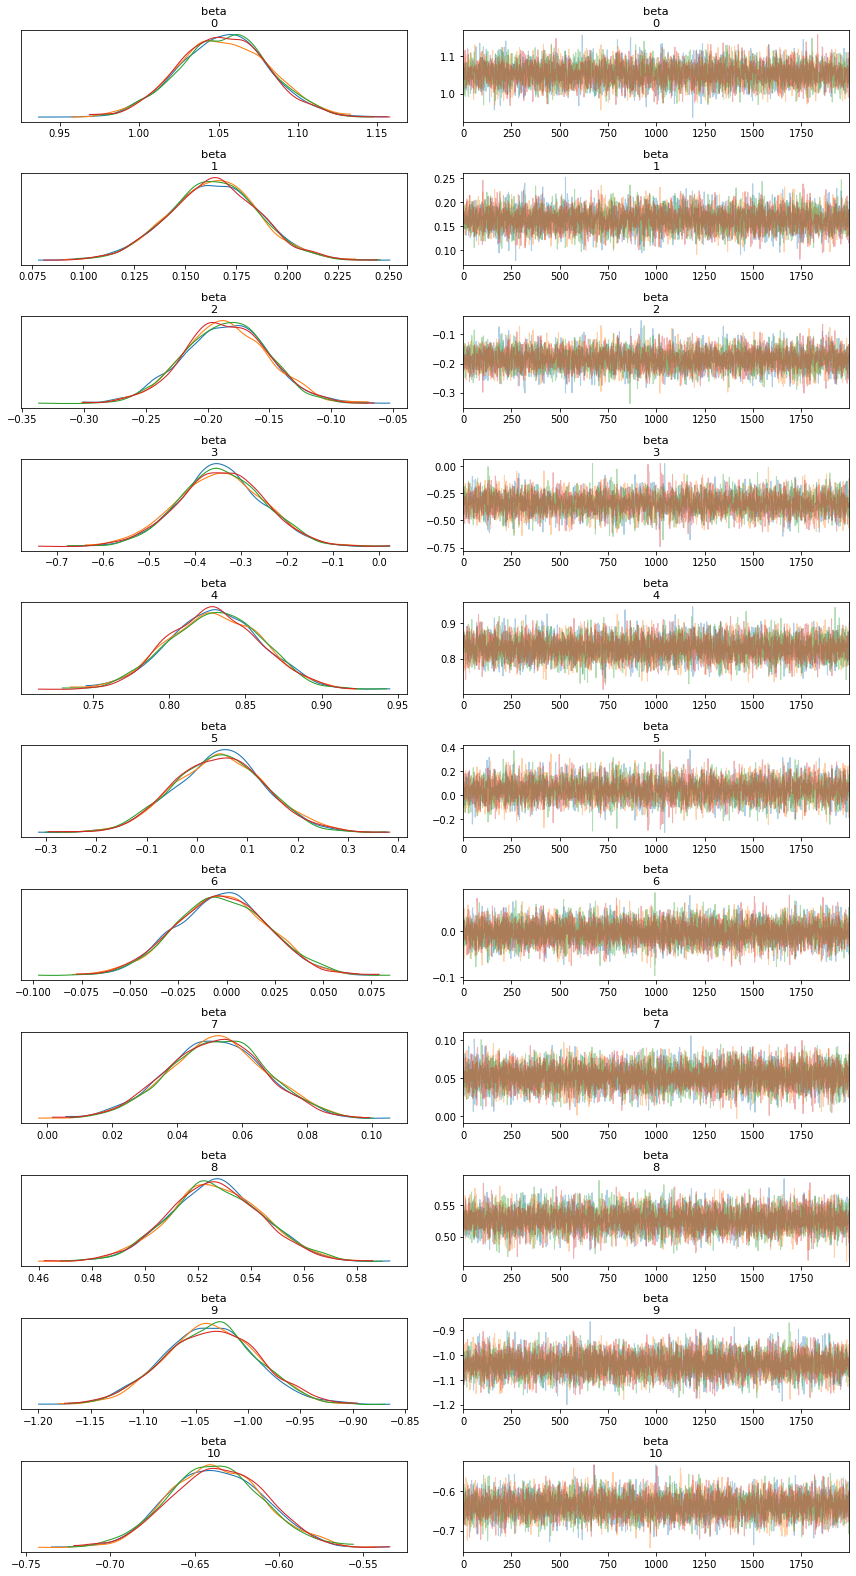

In [17]:
az.plot_trace(posterior_base_az, var_names = ['beta'], compact=False)
plt.tight_layout()
plt.show()

In [18]:
log_lik = fit_base.stan_variable("log_lik")
print(type(log_lik))

<class 'numpy.ndarray'>


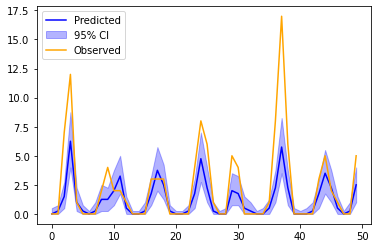

In [21]:
preds_y = posterior_base_az['posterior']['y_pred'].mean(axis=0)
y_star = preds_y.median(axis=0)
y_star_up = np.percentile(preds_y, 97.5, axis=0)
y_star_low = np.percentile(preds_y, 2.5, axis=0)
xx = np.arange(0, 50)
plt.plot(xx, y_star[xx], label="Predicted", color='blue')
plt.fill_between(xx, y_star_low[xx], y_star_up[xx], alpha=0.3, label="95% CI", color='blue')
plt.plot(xx, Y.loc[xx, 'Count_180'], label="Observed", color='orange')
plt.legend()
plt.show()

In [174]:
# Crea un oggetto InferenceData contenente log_lik
#inference_data = az.from_cmdstanpy(fit, log_likelihood={"log_lik": log_lik})

# Calcola e stampa WAIC
waic_result = az.waic(fit_base, var_name="log_lik")
print("WAIC: ", waic_result)

# Calcola e stampa LOO
loo_result = az.loo(fit_base, var_name="log_lik")
print("LOO: ", loo_result)

C:\Users\leoma\anaconda3\Lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


WAIC:  Computed from 8000 posterior samples and 3808 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -5432.25   117.32
p_waic       27.06        -

There has been a warning during the calculation. Please check the results.
LOO:  Computed from 8000 posterior samples and 3808 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -5432.28   117.32
p_loo       27.09        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     3808  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



Now we remove some variables, through two methods:\
    1. Variable selection through **SSVS**\
    2. Hard shrinkage in the posterior of the betas   
    
The code for the SSVS is on R in its folder, while the hard shrinkage will be in this file.

Given the SSVS paradigm, the covariates to remove are *max_consecutive_highwind_days*, *Densità*, *count_highwind*

In [12]:
##Code for hard shrinkage, hopefully same result

In [23]:
X = X.drop(columns=['max_consecutive_highwind_days', 'Densità', 'count_highwind'])

In [30]:
var_sel_model = """

data {
  int<lower=1> N; // Number of observations
  int<lower=1> P; // Covariate number

  array[N] int<lower=0> y; // Count data
  matrix[N, P] X; // Predictor matrix
}

parameters {
  vector[P] beta; // Coefficients for predictors
}

transformed parameters {
    vector[N] lambda;
    vector[N] fix_eff;

    fix_eff = X * beta;

    lambda = exp(fix_eff);
}

model {

  beta ~ normal(0, 2);
  y[1:N] ~ poisson(lambda[1:N]);

}
generated quantities{
 vector[N] log_lik;
 vector[N] y_pred;
 
 for(i in 1:N){
   log_lik[i] = poisson_lpmf(y[i]|lambda[i]);
   y_pred[i] = poisson_rng(lambda[i]);
}
}


"""

stan_file = "./stan/var_sel_base.stan"

with open(stan_file, "w") as f:
    print(base_model, file=f)

var_sel_base = CmdStanModel(stan_file=stan_file)

19:01:14 - cmdstanpy - INFO - compiling stan file /var/folders/h5/sljgddhd1clgfh2_bw619vb80000gn/T/tmpq45ynxdc/tmp093j2a20.stan to exe file /Users/beo/Desktop/Statistical Learning/Bayesian Statistics/Bayesian_Project/main/Modello/stan/var_sel_base
19:01:57 - cmdstanpy - INFO - compiled model executable: /Users/beo/Desktop/Statistical Learning/Bayesian Statistics/Bayesian_Project/main/Modello/stan/var_sel_base


In [31]:
data = {
    "N": len(Y),
    "P": X.shape[1],
    "nyears": 13,
    "nstations": 45,
    "station": stations,
    "year": years,
    "y": Y['Count_180'],
    "X": X
}


fit_var_sel = var_sel_base.sample(data=data, chains=4, parallel_chains=4, 
    iter_warmup=300, iter_sampling=200)
posterior_val_sel_az = az.from_cmdstanpy(fit_var_sel)

19:02:02 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:02:15 - cmdstanpy - INFO - CmdStan done processing.


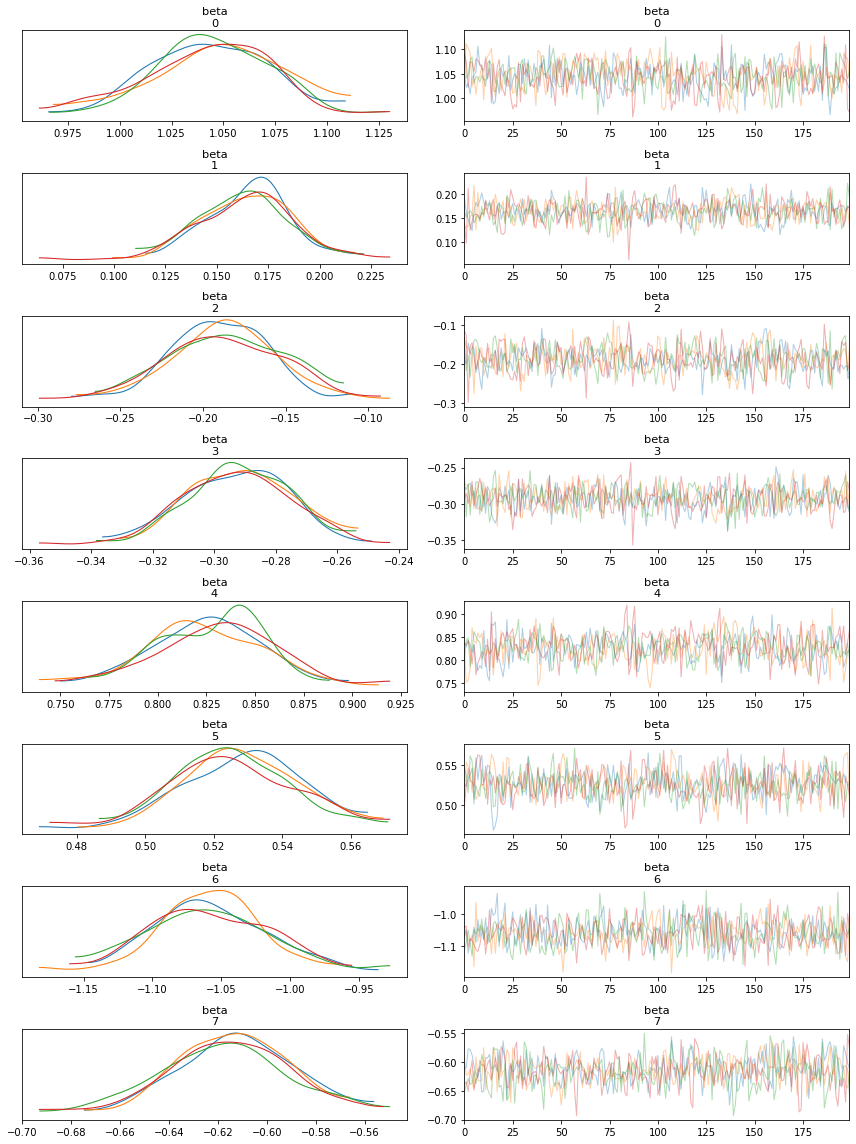

In [32]:
az.plot_trace(posterior_val_sel_az, var_names = ['beta'], compact=False)
plt.tight_layout()
plt.show()

In [27]:
log_lik = fit_var_sel.stan_variable("log_lik")
print(type(log_lik))

<class 'numpy.ndarray'>


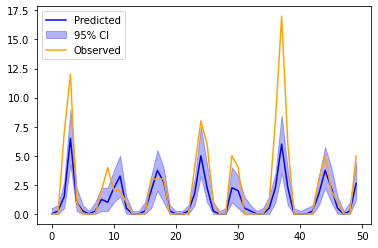

In [33]:
preds_y = posterior_val_sel_az['posterior']['y_pred'].mean(axis=0)
y_star = preds_y.median(axis=0)
y_star_up = np.percentile(preds_y, 97.5, axis=0)
y_star_low = np.percentile(preds_y, 2.5, axis=0)
xx = np.arange(0, 50)
plt.plot(xx, y_star[xx], label="Predicted", color='blue')
plt.fill_between(xx, y_star_low[xx], y_star_up[xx], alpha=0.3, label="95% CI", color='blue')
plt.plot(xx, Y.loc[xx, 'Count_180'], label="Observed", color='orange')
plt.legend()
plt.show()

In [34]:
# Crea un oggetto InferenceData contenente log_lik
#inference_data = az.from_cmdstanpy(fit, log_likelihood={"log_lik": log_lik})

# Calcola e stampa WAIC
waic_result = az.waic(fit_var_sel, var_name="log_lik")
print("WAIC: ", waic_result)

# Calcola e stampa LOO
loo_result = az.loo(fit_var_sel, var_name="log_lik")
print("LOO: ", loo_result)

/Users/beo/opt/anaconda3/lib/python3.9/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


WAIC:  Computed from 800 posterior samples and 3808 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -5431.43   117.25
p_waic       25.79        -

There has been a warning during the calculation. Please check the results.
LOO:  Computed from 800 posterior samples and 3808 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -5431.56   117.25
p_loo       25.92        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     3808  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



# Fit improvement
The threshold of 180 is very unlikely to be overcomed, with respect to the 120-threshold.\
This result in the presence of more zeros, and indeed *too much zeros*.\
The method for overcoming this issue is the **zero inflated Poisson** and the following is the code to implement this metodologies.

In [19]:
#Code for improve the fit

### Next step:
We add the factor accounting for different years.

In [35]:
year_model = """

data {
  int<lower=1> N; // Number of observations
  int<lower=1> P; // Covariate number
  int<lower=1> nyears;

  array[N] int<lower=1> year;

  array[N] int<lower=0> y; // Count data
  matrix[N, P] X; // Predictor matrix
}

parameters {
  vector[P] beta; // Coefficients for predictors
  vector[nyears] xi; // Random effects for years
}

transformed parameters {
    vector[N] lambda;
    vector[N] fix_eff;
    vector[N] intercept;

    fix_eff = X * beta;
    intercept = xi[year];

    lambda = exp(fix_eff + intercept);
}

model {

  beta ~ normal(0, 2);
  y[1:N] ~ poisson(lambda[1:N]);

  xi ~ normal(0, 2);
}
generated quantities{
 vector[N] log_lik;
 vector[N] y_pred;
 
 for(i in 1:N){
   log_lik[i] = poisson_lpmf(y[i]|lambda[i]);
   y_pred[i] = poisson_rng(lambda[i]);
}
}


"""

stan_file = "./stan/years.stan"

with open(stan_file, "w") as f:
    print(year_model, file=f)

model_year = CmdStanModel(stan_file=stan_file)

19:02:56 - cmdstanpy - INFO - compiling stan file /var/folders/h5/sljgddhd1clgfh2_bw619vb80000gn/T/tmp1z91hqbu/tmpntmv0zyh.stan to exe file /Users/beo/Desktop/Statistical Learning/Bayesian Statistics/Bayesian_Project/main/Modello/stan/years
19:03:42 - cmdstanpy - INFO - compiled model executable: /Users/beo/Desktop/Statistical Learning/Bayesian Statistics/Bayesian_Project/main/Modello/stan/years


In [36]:
data = {
    "N": len(Y),
    "P": X.shape[1],
    "nyears": 13,
    "nstations": 45,
    "station": stations,
    "year": years,
    "y": Y['Count_180'],
    "X": X
}


fit_years = model_year.sample(data=data, chains=4, parallel_chains=4, 
    iter_warmup=300, iter_sampling=200)
posterior_years_az = az.from_cmdstanpy(fit_years)

19:03:43 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:04:05 - cmdstanpy - INFO - CmdStan done processing.


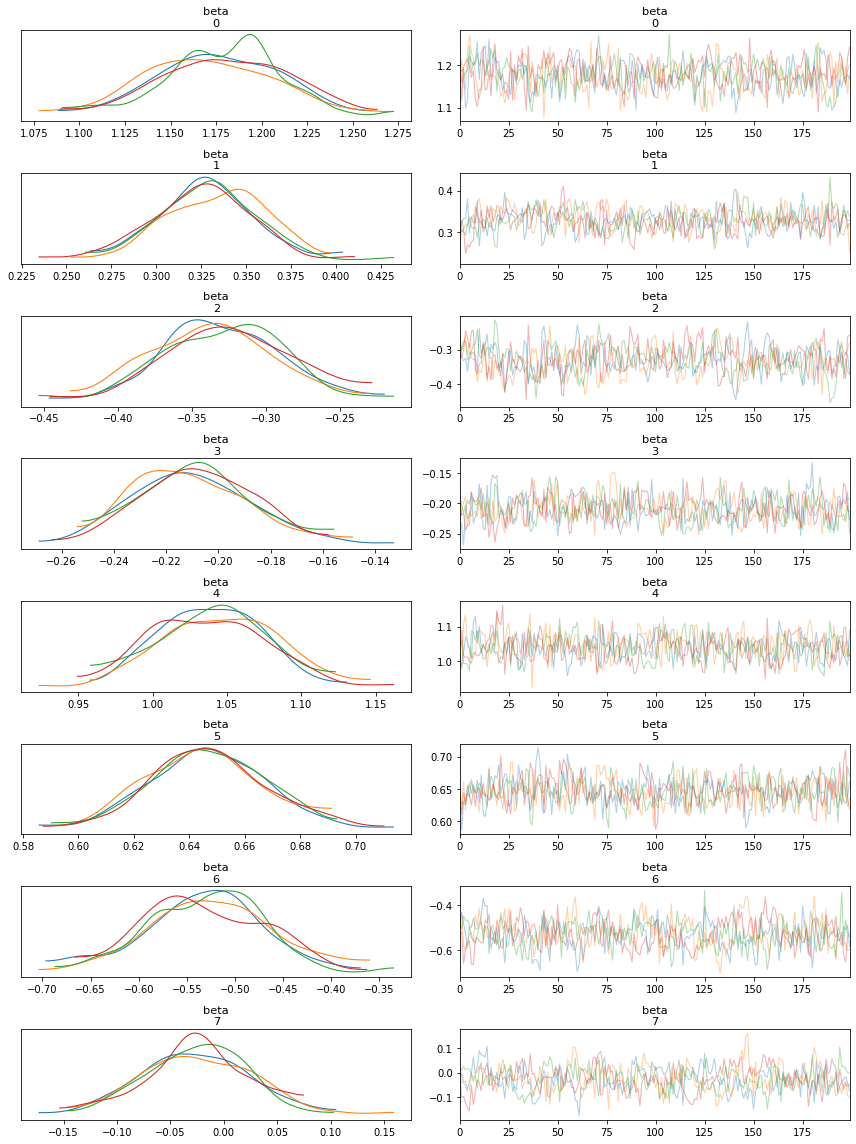

In [37]:
az.plot_trace(posterior_years_az, var_names = ['beta'], compact=False)
plt.tight_layout()
plt.show()

In [24]:
log_lik = fit_years.stan_variable("log_lik")
print(type(log_lik))

<class 'numpy.ndarray'>


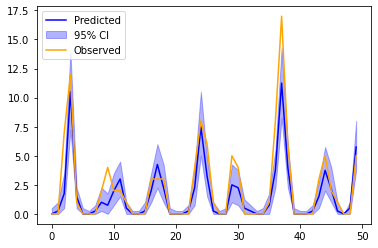

In [38]:
preds_y = posterior_years_az['posterior']['y_pred'].mean(axis=0)
y_star = preds_y.median(axis=0)
y_star_up = np.percentile(preds_y, 97.5, axis=0)
y_star_low = np.percentile(preds_y, 2.5, axis=0)
xx = np.arange(0, 50)
plt.plot(xx, y_star[xx], label="Predicted", color='blue')
plt.fill_between(xx, y_star_low[xx], y_star_up[xx], alpha=0.3, label="95% CI", color='blue')
plt.plot(xx, Y.loc[xx, 'Count_180'], label="Observed", color='orange')
plt.legend()
plt.show()

In [39]:
# Crea un oggetto InferenceData contenente log_lik
#inference_years = az.from_cmdstanpy(fit_years, log_likelihood={"log_lik": log_lik})

# Calcola e stampa WAIC
waic_result = az.waic(fit_years, var_name="log_lik")
print("WAIC: ", waic_result)

# Calcola e stampa LOO
loo_result = az.loo(fit_years, var_name="log_lik")
print("LOO: ", loo_result)

/Users/beo/opt/anaconda3/lib/python3.9/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


WAIC:  Computed from 800 posterior samples and 3808 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -4813.41   110.72
p_waic       56.89        -

There has been a warning during the calculation. Please check the results.


/Users/beo/opt/anaconda3/lib/python3.9/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


LOO:  Computed from 800 posterior samples and 3808 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -4813.81   110.75
p_loo       57.30        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     3807  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         1    0.0%
   (1, Inf)   (very bad)    0    0.0%



## Stations factor

After this upgrade, we account for the differences in the *stations* factor.

In [40]:
station_model = """

data {
  int<lower=1> N; // Number of observations
  int<lower=1> P; // Covariate number
  int<lower=1> nyears;
  int<lower=1> nstations;

  array[N] int<lower=1> year;
  array[N] int<lower=1> stations;

  array[N] int<lower=0> y; // Count data
  matrix[N, P] X; // Predictor matrix
}

parameters {
  vector[P] beta; // Coefficients for predictors
  vector[nyears] xi; // Random effects for years
  vector[nstations] eta;//For the stations
}

transformed parameters {
    vector[N] lambda;
    vector[N] fix_eff;
    vector[N] intercept;

    fix_eff = X * beta;
    intercept = xi[year] + eta[stations];

    lambda = exp(fix_eff + intercept);
}

model {

  beta ~ normal(0, 2);
  y[1:N] ~ poisson(lambda[1:N]);

  xi ~ normal(0, 2);
  eta ~ normal(0, 2);
}
generated quantities{
 vector[N] log_lik;
 vector[N] y_pred;
 
 for(i in 1:N){
   log_lik[i] = poisson_lpmf(y[i]|lambda[i]);
   y_pred[i] = poisson_rng(lambda[i]);
}
}

"""

stan_file = "./stan/station.stan"

with open(stan_file, "w") as f:
    print(station_model, file=f)

model_station = CmdStanModel(stan_file=stan_file)

19:05:02 - cmdstanpy - INFO - compiling stan file /var/folders/h5/sljgddhd1clgfh2_bw619vb80000gn/T/tmpcjygxpot/tmpv_40pyit.stan to exe file /Users/beo/Desktop/Statistical Learning/Bayesian Statistics/Bayesian_Project/main/Modello/stan/station
19:05:49 - cmdstanpy - INFO - compiled model executable: /Users/beo/Desktop/Statistical Learning/Bayesian Statistics/Bayesian_Project/main/Modello/stan/station


In [41]:
data = {
    "N": len(Y),
    "P": X.shape[1],
    "nyears": 13,
    "nstations": 45,
    "stations": stations,
    "year": years,
    "y": Y['Count_180'],
    "X": X
}


fit_stations = model_station.sample(data=data, chains=4, parallel_chains=4, 
    iter_warmup=300, iter_sampling=200)
posterior_station_az = az.from_cmdstanpy(fit_stations)

19:05:52 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:08:30 - cmdstanpy - INFO - CmdStan done processing.


19:08:32 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 3 had 1 iterations at max treedepth (0.5%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


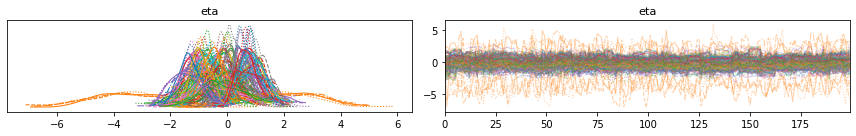

In [42]:
az.plot_trace(posterior_station_az, var_names = ['eta'], compact=True)
plt.tight_layout()
plt.show()

In [43]:
eta = posterior_station_az['posterior']['eta']
eta
len(np.unique(stations))

45

In [44]:
inference = []
for i in range(len(np.unique(stations))):
    ar1 = eta[0, :, i]
    ar2 = eta[1, :, i]
    ar3 = eta[2, :, i]
    ar4 = eta[3, :, i]
    current_iteration_df = np.concatenate((ar1, ar2, ar3, ar4), axis=0)
    inference.append(current_iteration_df)

len(current_iteration_df)
len(inference)

45

In [31]:
df = pd.DataFrame(inference).transpose()
df.shape
df.columns = np.unique(stations_original)
df.columns.values

array([ 5707,  5710,  5717,  5718,  5719,  5721,  5725,  5730,  5732,
        5735,  5738,  5739,  5742,  5749,  5750,  5952,  5960,  6582,
        6665,  6691,  6804,  6818,  6832,  6884,  6904,  9856,  9861,
        9882,  9899,  9925,  9972,  9991,  9997, 10025, 10041, 10081,
       10171, 10270, 10282, 10288, 10437, 10454, 10463, 10584, 12020],
      dtype=int64)

In [32]:
csv_path = '../Datasets/eta_180.csv'
data = pd.DataFrame(df)
# Save the DataFrame to a CSV file
data.to_csv(csv_path, index=False)

In [33]:
log_lik = fit_stations.stan_variable("log_lik")
print(type(log_lik))

<class 'numpy.ndarray'>


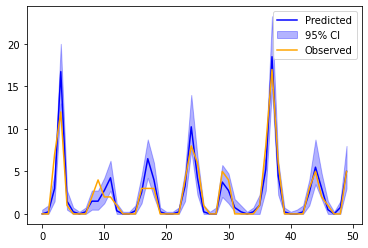

In [45]:
preds_y = posterior_station_az['posterior']['y_pred'].mean(axis=0)
y_star = preds_y.median(axis=0)
y_star_up = np.percentile(preds_y, 97.5, axis=0)
y_star_low = np.percentile(preds_y, 2.5, axis=0)
xx = np.arange(0, 50)
plt.plot(xx, y_star[xx], label="Predicted", color='blue')
plt.fill_between(xx, y_star_low[xx], y_star_up[xx], alpha=0.3, label="95% CI", color='blue')
plt.plot(xx, Y.loc[xx, 'Count_180'], label="Observed", color='orange')
plt.legend()
plt.show()

In [46]:
# Crea un oggetto InferenceData contenente log_lik
#inference_stations = az.from_cmdstanpy(fit_stations, log_likelihood={"log_lik": log_lik})

# Calcola e stampa WAIC
waic_result = az.waic(fit_stations, var_name="log_lik")
print("WAIC: ", waic_result)

# Calcola e stampa LOO
loo_result = az.loo(fit_stations, var_name="log_lik")
print("LOO: ", loo_result)

/Users/beo/opt/anaconda3/lib/python3.9/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


WAIC:  Computed from 800 posterior samples and 3808 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -3838.52    85.30
p_waic      106.69        -

There has been a warning during the calculation. Please check the results.


/Users/beo/opt/anaconda3/lib/python3.9/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


LOO:  Computed from 800 posterior samples and 3808 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -3839.32    85.32
p_loo      107.49        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     3805   99.9%
 (0.5, 0.7]   (ok)          2    0.1%
   (0.7, 1]   (bad)         1    0.0%
   (1, Inf)   (very bad)    0    0.0%



## Proper space model

Now, we should take into account the spatial dependance of the model, through an appropriate space model (main folder with R files) and put again this ideas into this model.

In [47]:
space_model = """

data {
  int<lower=1> N; // Number of observations
  int<lower=1> P; // Covariate number
  int<lower=1> nyears;
  int<lower=1> nstations;

  array[N] int<lower=1> year;
  array[N] int<lower=1> stations;

  array[N] int<lower=0> y; // Count data
  matrix[N, P] X; // Predictor matrix
  real phi;
  matrix[nstations, nstations] distances;
}

transformed data {
    matrix[nstations,nstations] H = exp(-phi * distances);

}

parameters {
  vector[P] beta; // Coefficients for predictors
  vector[nyears] xi; // Random effects for years
  vector[nstations] eta;//For the stations
}

transformed parameters {
    vector[N] lambda;
    vector[N] fix_eff;
    vector[N] intercept;
    matrix[nstations,nstations] Sigma_s = H; //To be added the variance
    matrix[nstations,nstations] Lw = cholesky_decompose(Sigma_s);


    fix_eff = X * beta;
    intercept = xi[year] + eta[stations];

    lambda = exp(fix_eff + intercept);
}

model {

  beta ~ normal(0, 2);
  y[1:N] ~ poisson(lambda[1:N]);

  xi ~ normal(0, 2);
  eta ~ multi_normal_cholesky(rep_vector(0, nstations), H);
}
generated quantities{
 vector[N] log_lik;
 vector[N] y_pred;
 
 for(i in 1:N){
   log_lik[i] = poisson_lpmf(y[i]|lambda[i]);
   y_pred[i] = poisson_rng(lambda[i]);
}
}

"""

stan_file = "./stan/space.stan"

with open(stan_file, "w") as f:
    print(space_model, file=f)

model_space = CmdStanModel(stan_file=stan_file)

19:24:04 - cmdstanpy - INFO - compiling stan file /var/folders/h5/sljgddhd1clgfh2_bw619vb80000gn/T/tmp4o0w5cw6/tmpjmrurl_y.stan to exe file /Users/beo/Desktop/Statistical Learning/Bayesian Statistics/Bayesian_Project/main/Modello/stan/space
19:25:07 - cmdstanpy - INFO - compiled model executable: /Users/beo/Desktop/Statistical Learning/Bayesian Statistics/Bayesian_Project/main/Modello/stan/space


In [48]:
phi = 62
distances = pd.read_csv("../Datasets/distances.csv", index_col=0)

In [49]:
data = {
    "N": len(Y),
    "P": X.shape[1],
    "nyears": 13,
    "nstations": 45,
    "stations": stations,
    "year": years,
    "y": Y['Count_180'],
    "X": X,
    "phi": phi,
    "distances": distances
}


fit_space = model_space.sample(data=data, chains=4, parallel_chains=4, 
    iter_warmup=300, iter_sampling=200)
posterior_space_az = az.from_cmdstanpy(fit_space)

19:25:45 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:27:56 - cmdstanpy - INFO - CmdStan done processing.


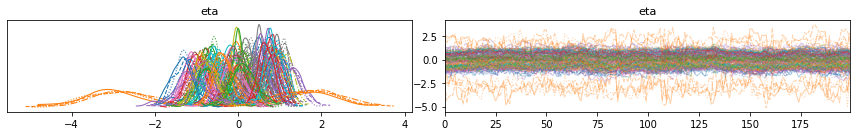

In [50]:
az.plot_trace(posterior_space_az, var_names = ['eta'], compact=True)
plt.tight_layout()
plt.show()

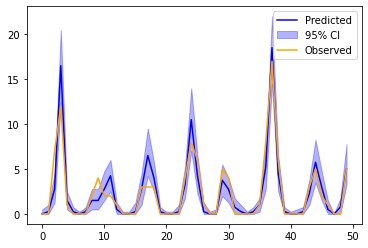

In [51]:
preds_y = posterior_space_az['posterior']['y_pred'].mean(axis=0)
y_star = preds_y.median(axis=0)
y_star_up = np.percentile(preds_y, 97.5, axis=0)
y_star_low = np.percentile(preds_y, 2.5, axis=0)
xx = np.arange(0, 50)
plt.plot(xx, y_star[xx], label="Predicted", color='blue')
plt.fill_between(xx, y_star_low[xx], y_star_up[xx], alpha=0.3, label="95% CI", color='blue')
plt.plot(xx, Y.loc[xx, 'Count_180'], label="Observed", color='orange')
plt.legend()
plt.show()

In [53]:
# Crea un oggetto InferenceData contenente log_lik
#inference_stations = az.from_cmdstanpy(fit_stations, log_likelihood={"log_lik": log_lik})

# Calcola e stampa WAIC
waic_result = az.waic(fit_space, var_name="log_lik")
print("WAIC: ", waic_result)

# Calcola e stampa LOO
loo_result = az.loo(fit_space, var_name="log_lik")
print("LOO: ", loo_result)

/Users/beo/opt/anaconda3/lib/python3.9/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


WAIC:  Computed from 800 posterior samples and 3808 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -3837.54    85.02
p_waic      103.94        -

There has been a warning during the calculation. Please check the results.
LOO:  Computed from 800 posterior samples and 3808 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -3838.34    85.05
p_loo      104.74        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     3803   99.9%
 (0.5, 0.7]   (ok)          5    0.1%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



## ZIP

Despite we talked about the zip in one of the first chunck of the code, it is a very computationally intensive algorithm and so we moved here for now.

In [54]:
# Improving ZIP functions
spt_tools = \
"""
int num_zeros(array[] int y) {
    int sum = 0;
    for (n in 1:size(y))
      sum += (y[n] == 0);
    return sum;
  }
"""

# Write functions to file
stan_file = "stan/spt_tools.stan"
with open(stan_file, "w") as f:
    print(spt_tools, file=f)

In [68]:
zip_model = """
functions {
    #include "./spt_tools.stan"
}

data {
  int<lower=1> N; // Number of observations
  int<lower=1> P; // Covariate number
  int<lower=1> nyears;
  int<lower=1> nstations;

  array[N] int<lower=1> year;
  array[N] int<lower=1> stations;

  array[N] int<lower=0> y; // Count data
  matrix[N, P] X; // Predictor matrix
  
  real phi;
  matrix[nstations, nstations] distances;
  
  int N1;
  matrix[N1, P] X1; // Non-zero Predictor matrix
  array[N1] int<lower=1> year1;
  array[N1] int<lower=1> stations1;
  
}

transformed data {
  matrix[nstations,nstations] H = exp(-phi * distances);


  int<lower = 0> N_zero = num_zeros(y);
  array[N1] int<lower = 1> y_nonzero;
  int N_nonzero = 0;
  for (n in 1:N) {
    if (y[n] == 0) continue;
    N_nonzero += 1;
    y_nonzero[N_nonzero] = y[n];
  }
}

parameters {
  vector[P] beta; // Coefficients for predictors
  real<lower=0, upper=1> theta; // Probability of excess zeros
  
  vector[nyears] xi; // Random effects for years
  vector[nstations] eta;//For the stations
}

transformed parameters {
  
    vector[N1] lambda;
    vector[N1] fix_eff;
    vector[N1] intercept;
    matrix[nstations,nstations] Sigma_s = H; //To be added the variance
    matrix[nstations,nstations] Lw = cholesky_decompose(Sigma_s);

    fix_eff = X1 * beta;
    intercept = eta[stations1] + xi[year1];

    lambda = exp(fix_eff + intercept);
    
}

model {
  beta ~ normal(0, 2);
  theta ~ beta(0.5, 0.5); // Prior for excess zeros probability
  
  xi ~ normal(0, 2);
  eta ~ multi_normal_cholesky(rep_vector(0, nstations), H);

target
     += N_zero
          * log_sum_exp(bernoulli_lpmf(1 | theta),
                        bernoulli_lpmf(0 | theta)
                          + poisson_lpmf(0 | lambda));
   target += N_nonzero * bernoulli_lpmf(0 | theta);
   target += poisson_lpmf(y_nonzero | lambda);
}

generated quantities{
 vector[N] log_lik;
 vector[N1] y_pred;
 
 for(i in 1:N){
   log_lik[i] = N_zero
          * log_sum_exp(bernoulli_lpmf(1|theta),
                        bernoulli_lpmf(0|theta)
                          + poisson_lpmf(0|lambda));
   log_lik[i] = N_nonzero * bernoulli_lpmf(0|theta);
   log_lik[i] = poisson_lpmf(y_nonzero|lambda);
   
   y_pred[i] = poisson_rng(lambda[i]); // da capire come inserirlo

}

}


"""

stan_file = "stan/zip.stan"

with open(stan_file, "w") as f:
    print(zip_model, file=f)

model_zip = CmdStanModel(stan_file=stan_file)

19:59:57 - cmdstanpy - INFO - compiling stan file /var/folders/h5/sljgddhd1clgfh2_bw619vb80000gn/T/tmpk8l2cjje/tmpg6o4js22.stan to exe file /Users/beo/Desktop/Statistical Learning/Bayesian Statistics/Bayesian_Project/main/Modello/stan/zip
20:00:54 - cmdstanpy - INFO - compiled model executable: /Users/beo/Desktop/Statistical Learning/Bayesian Statistics/Bayesian_Project/main/Modello/stan/zip


In [66]:
#N1 n-nzero
Nzero = sum((Y['Count_180'])==0)

N1 = len(Y) - Nzero

# Identify rows in Y where 'Count_180' column equals zero
rows_to_drop = Y[Y['Count_180'] == 0].index

# Create a new DataFrame X1 by copying X and dropping rows identified in Y
X1 = X.drop(rows_to_drop)

stations1 = pd.read_csv("../Datasets/stazzip.csv")
stations1 = stations1['x']
len(stations1)
unique_values = sorted(set(stations1))
mapping_dict = {value: index + 1 for index, value in enumerate(unique_values)}
stations1 = [mapping_dict[value] for value in stations1]
year1 = pd.read_csv("../Datasets/yearzip.csv")
year1 = year1['x']-2009
year1

0        1
1        1
2        1
3        2
4        2
        ..
1262     9
1263    10
1264    10
1265    12
1266    13
Name: x, Length: 1267, dtype: int64

In [69]:
data = {
    "N": len(Y),
    "P": X.shape[1],
    "nyears": 13,
    "nstations": 45,
    "stations": transformed_stations,
    "year": years,
    "y": Y['Count_180'],
    "X": X,
    "phi" : phi,
    "distances" : distances,
    "N1" : N1,
    "X1" : X1,
    "stations1" : stations1,
    "year1" : year1
}

# require 40 min for iter_warmup=1000 and iter_sampling=2000
fit_zip = model_zip.sample(data=data, chains=4, parallel_chains=4, 
    iter_warmup=1000, iter_sampling=2000)
posterior_zip_az = az.from_cmdstanpy(fit_zip)

20:04:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:18:51 - cmdstanpy - INFO - CmdStan done processing.
20:18:51 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: vector[uni] indexing: accessing element out of range. index 1268 out of range; expecting index to be between 1 and 1267 (in 'zip.stan', line 93, column 3 to column 38)
	Exception: vector[uni] indexing: accessing element out of range. index 1268 out of range; expecting index to be between 1 and 1267 (in 'zip.stan', line 93, column 3 to column 38)
	Exception: vector[uni] indexing: accessing element out of range. index 1268 out of range; expecting index to be between 1 and 1267 (in 'zip.stan', line 93, column 3 to column 38)
	Exception: vector[uni] indexing: accessing element out of range. index 1268 out of range; expecting index to be between 1 and 1267 (in 'zip.stan', line 93, column 3 to column 38)
	Exception: vector[uni] indexing: accessing element out of range. index 1268 out of range; expecting index to be between 1 and 1267 (in 'zip.stan', line 93, col

In [64]:
az.to_netcdf(posterior_zip_az, "../Dati_iniziali/stan_zip.netcdf", engine='h5netcdf', coords=None, dims=None)

FileNotFoundError: [Errno 2] Unable to create file (unable to open file: name = '/Users/beo/Desktop/Statistical Learning/Bayesian Statistics/Bayesian_Project/main/Dati_iniziali/stan_zip.netcdf', errno = 2, error message = 'No such file or directory', flags = 13, o_flags = 602)

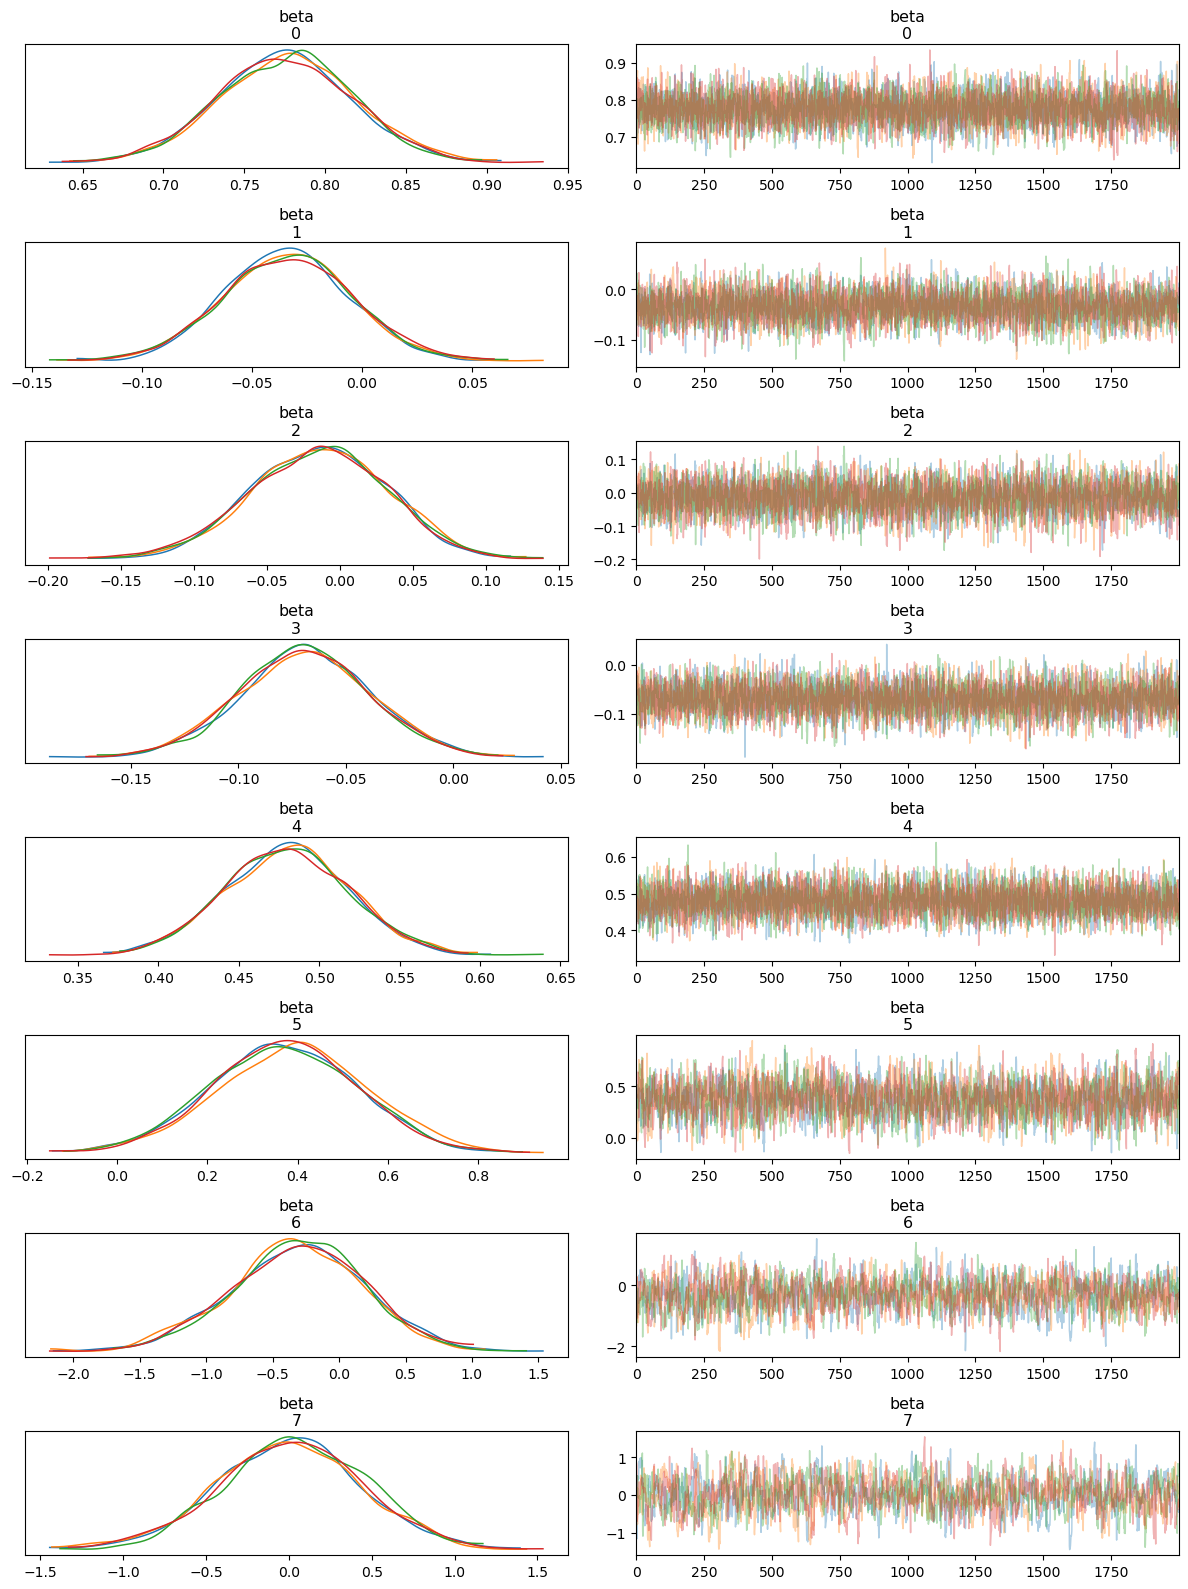

In [167]:
az.plot_trace(posterior_zip_az, var_names = ['beta'], compact=False)
plt.tight_layout()
plt.show()

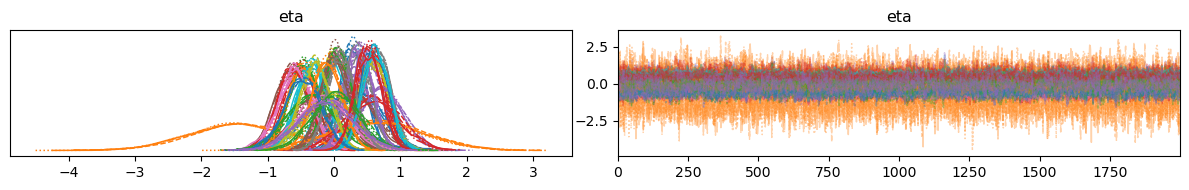

In [168]:
az.plot_trace(posterior_zip_az, var_names = ['eta'], compact=True)
plt.tight_layout()
plt.show()

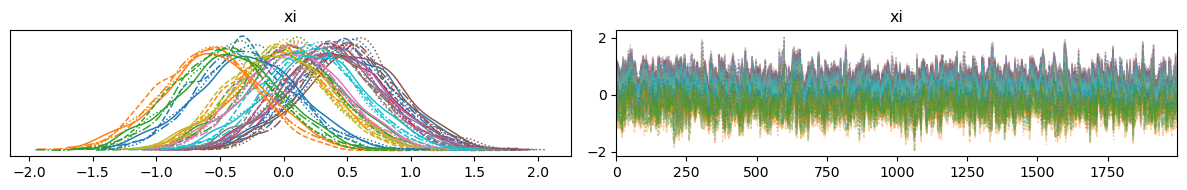

In [169]:
az.plot_trace(posterior_zip_az, var_names = ['xi'], compact=True)
plt.tight_layout()
plt.show()

In [ ]:
preds_y = posterior_zip_az['posterior']['y_pred'].mean(axis=0)
y_star = preds_y.median(axis=0)
y_star_up = np.percentile(preds_y, 97.5, axis=0)
y_star_low = np.percentile(preds_y, 2.5, axis=0)
xx = np.arange(0, 50)
plt.plot(xx, y_star[xx], label="Predicted", color='blue')
plt.fill_between(xx, y_star_low[xx], y_star_up[xx], alpha=0.3, label="95% CI", color='blue')
plt.plot(xx, Y.loc[xx, 'Count_180'], label="Observed", color='orange')
plt.legend()
plt.show()

In [166]:
# Crea un oggetto InferenceData contenente log_lik
#inference_stations = az.from_cmdstanpy(fit_stations, log_likelihood={"log_lik": log_lik})

# Calcola e stampa WAIC
waic_result = az.waic(fit_zip, var_name="log_lik")
print("WAIC: ", waic_result)

# Calcola e stampa LOO
loo_result = az.loo(fit_zip, var_name="log_lik")
print("LOO: ", loo_result)

C:\Users\leoma\anaconda3\Lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


WAIC:  Computed from 8000 posterior samples and 3808 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -9860904.07     0.00
p_waic    117696.73        -

There has been a warning during the calculation. Please check the results.


C:\Users\leoma\anaconda3\Lib\site-packages\arviz\stats\stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


LOO:  Computed from 8000 posterior samples and 3808 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -9837230.18     0.00
p_loo    94022.84        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)        0    0.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad) 3808  100.0%

